In [4]:
cd ..

/home/wesg/research/neuron-stats


In [5]:
# autoreload
%load_ext autoreload
%autoreload 2

import os
import pickle
import argparse
import einops
import torch
import numpy as np
import pandas as pd
from transformer_lens import HookedTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import datasets
import torch

torch.set_grad_enabled(False)

%matplotlib inline

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [6]:
model_names = ['stanford-gpt2-small-a', 'stanford-gpt2-medium-a', 'pythia-160m']
ndfs = {}
for model_name in model_names:
    neuron_df = pd.read_csv(f'dataframes/neuron_dfs/{model_name}.csv')
    neuron_df['excess_corr'] = neuron_df['mean_corr'] - neuron_df['mean_baseline']
    ndfs[model_name] = neuron_df

In [4]:
# display all cols
pd.set_option('display.max_columns', None)
df = ndfs['stanford-gpt2-medium-a']
df.head()

,layer,neuron,max_corr,mean_corr,min_corr,max_baseline,min_baseline,mean_baseline,w_in_norm,input_bias,w_out_norm,in_out_sim,l2_penalty,mean,var,skew,kurt,vocab_mean,vocab_var,vocab_skew,vocab_kurt,sparsity,excess_corr
0,0,0,0.4646,0.439825,0.4092,0.3500,0.3330,0.342250,0.370499,-0.388558,0.366136,0.079143,0.271325,-1.077630,0.410425,0.063839,2.780662,0.000301,0.000995,0.007442,2.978626,0.057869,0.097575
1,0,1,0.2600,0.228850,0.2119,0.1885,0.1608,0.168700,0.368054,-0.367035,0.340429,-0.070471,0.251356,-0.619509,0.104088,0.417814,4.443205,-0.000187,0.000939,0.017759,2.983132,0.057327,0.060150
2,0,2,0.5570,0.518625,0.4575,0.1963,0.1887,0.190875,0.395692,-0.539252,0.362820,0.166318,0.288211,-1.267382,0.312051,0.506417,3.808384,-0.000063,0.000957,-0.001548,3.005584,0.028301,0.327750
3,0,3,0.3880,0.340350,0.3157,0.2527,0.2285,0.240050,0.392904,-0.490780,0.355590,0.103022,0.280817,-1.150307,0.335263,0.261270,3.022481,-0.000015,0.000930,0.014691,2.992840,0.037805,0.100300
4,0,4,0.2878,0.263300,0.2396,0.1550,0.1460,0.150250,0.385215,-0.417577,0.337188,0.015654,0.262087,-0.711964,0.165003,0.494364,4.288840,0.000254,0.000920,-0.004821,3.000447,0.061776,0.113050


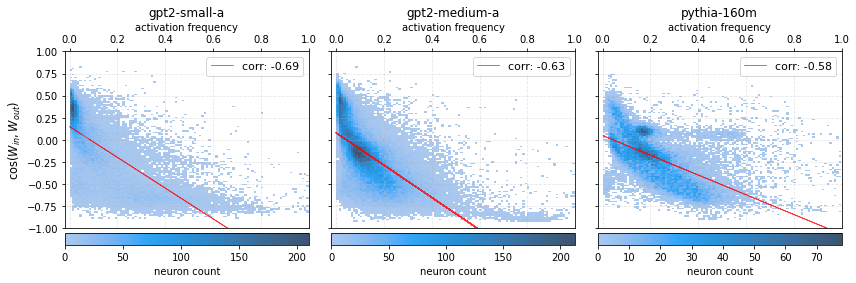

In [5]:
# 1 x 3 plot of sparsity vs in_out_sim
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for i, model_name in enumerate(model_names):
    df = ndfs[model_name]
    ax = axes[i]
    # adjust the colorbar to be horizontal and below the plot
    sns_plot = sns.histplot(df, x='sparsity', y='in_out_sim', ax=ax, cbar=True, bins=100, cbar_kws={'orientation': 'horizontal', 'pad':0.02})
    # label the colorbar
    cbar = sns_plot.collections[0].colorbar
    cbar.ax.set_xlabel('neuron count')

    # Move x-axis labels and ticks to the top
    ax.xaxis.set_label_position('top') 
    ax.xaxis.tick_top()

    ax.set_ylabel('$\cos(W_{in}, W_{out})$')
    ax.set_xlabel('activation frequency')
    ax.set_title(model_name.replace('stanford-', ''))

    x = df['sparsity']
    y = df['in_out_sim']
    corr = np.corrcoef(x, y)[0, 1]
    m, b = np.polyfit(x, y, 1)

    ax.plot(x, m*x + b, color='red', lw=0.8,alpha=0.8, label=f'corr: {corr:.2f}')
    ax.legend(loc='upper right', fontsize=11)


    ax.set_ylim(-1, 1)
    ax.set_xlim(-0.02, 1)
    ax.grid(alpha=0.3, linestyle='--')

# make y label larger
axes[0].set_ylabel('$\cos(W_{in}, W_{out})$', fontsize=11.5)


plt.tight_layout()

plt.savefig('figures/sparsity_vs_in_out_sim.png', dpi=150)

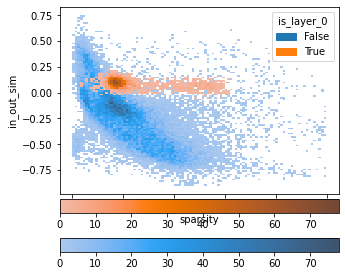

In [6]:
model_name = 'pythia-160m'
df = ndfs[model_name]
df['is_layer_0'] = df['layer'] == 0
fig, ax = plt.subplots(figsize=(5, 5))
sns_plot = sns.histplot(df, x='sparsity', y='in_out_sim', ax=ax, cbar=True, bins=100, cbar_kws={'orientation': 'horizontal', 'pad':0.02}, hue='is_layer_0')


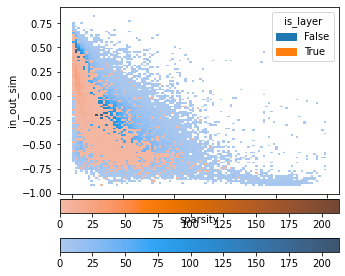

In [7]:
model_name = 'stanford-gpt2-medium-a'
df = ndfs[model_name]
df['is_layer'] = df['layer'] == 4
fig, ax = plt.subplots(figsize=(5, 5))
sns_plot = sns.histplot(df, x='sparsity', y='in_out_sim', ax=ax, cbar=True, bins=100, cbar_kws={'orientation': 'horizontal', 'pad':0.02}, hue='is_layer')


Text(0, 0.5, 'in_out_sim')

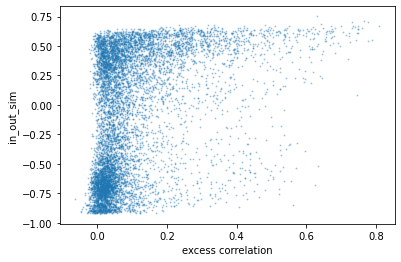

In [8]:
df_early = df.query('layer < 3 and layer > 0')
plt.scatter(df_early.excess_corr, df_early.in_out_sim, alpha=0.3, s=1)
plt.xlabel('excess correlation')
plt.ylabel('in_out_sim')

In [9]:
# # 1 x 3 plot of sparsity vs in_out_sim
# fig, axes = plt.subplots(1, 3, figsize=(12, 3.5), sharey=True)

# for i, model_name in enumerate(model_names):
#     df = ndfs[model_name]
#     ax = axes[i]
#     # adjust the colorbar to be horizontal and below the plot
#     sns_plot = sns.histplot(df, x='sparsity', y='in_out_sim', ax=ax, cbar=True, bins=100)
#     # label the colorbar with label rotated 180 degrees
#     if i == 2:
#         cbar = sns_plot.collections[0].colorbar
#         cbar.ax.set_ylabel('neuron count', rotation=270, labelpad=15)


#     # Move x-axis labels and ticks to the top
#     ax.xaxis.set_label_position('top') 
#     ax.xaxis.tick_top()

#     ax.set_ylabel('$\cos(W_{in}, W_{out})$')
#     ax.set_xlabel('activation frequency')
#     ax.set_title(model_name.replace('stanford-', ''))

#     x = df['sparsity']
#     y = df['in_out_sim']
#     corr = np.corrcoef(x, y)[0, 1]
#     m, b = np.polyfit(x, y, 1)

#     ax.plot(x, m*x + b, color='red', lw=0.8,alpha=0.8, label=f'$\\rho$ = {corr:.2f}')
#     ax.legend(loc='upper right')


#     ax.set_ylim(-1, 1)
#     ax.set_xlim(-0.02, 1)

# plt.tight_layout()

In [10]:
    # # Adjust the position of each colorbar
    # cbar.ax.set_position([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.02, ax.get_position().height])

## Weight redundancy 

In [17]:
model_name = 'pythia-160m'

model = HookedTransformer.from_pretrained(model_name)

Using pad_token, but it is not set yet.


Loaded pretrained model pythia-160m into HookedTransformer


In [9]:
def make_weight_sim_df(model_name):
    model = HookedTransformer.from_pretrained(model_name)
    print('finish loading modedl')
    W_out = model.W_out.detach().cpu().numpy()
    W_in = np.swapaxes(model.W_in.detach().cpu().numpy(), 1, 2)

    W_out_norm = W_out / np.linalg.norm(W_out, axis=-1)[:, :, None]
    W_in_norm = W_in / np.linalg.norm(W_in, axis=-1)[:, :, None]

    W_out_norm = einops.rearrange(W_out_norm, 'l n d -> (l n) d')
    W_in_norm = einops.rearrange(W_in_norm, 'l n d -> (l n) d')
    print('finished weights')
    W_out_cos = W_out_norm @ W_out_norm.T
    np.fill_diagonal(W_out_cos, 0)

    W_in_cos = W_in_norm @ W_in_norm.T
    np.fill_diagonal(W_in_cos, 0)
    print('finished cosine')
    min_out_sim = W_out_cos.min(axis=1)
    max_out_sim = W_out_cos.max(axis=1)
    max_abs_out_sim = np.abs(W_out_cos).max(axis=1)

    min_in_sim = W_in_cos.min(axis=1)
    max_in_sim = W_in_cos.max(axis=1)
    max_abs_in_sim = np.abs(W_in_cos).max(axis=1)
    print('finished min max')

    # make dataframe combining
    df = pd.DataFrame({
        'max_abs_out_sim': max_abs_out_sim,
        'max_abs_in_sim': max_abs_in_sim,
        'min_out_sim': min_out_sim,
        'min_in_sim': min_in_sim,
        'max_out_sim': max_out_sim,
        'max_in_sim': max_in_sim,
    })
    return df


In [11]:
model_names = ['stanford-gpt2-small-a', 'stanford-gpt2-medium-a', 'pythia-160m']
sim_dfs = {}
for model_name in model_names:
    sim_df = make_weight_sim_df(model_name)
    sim_dfs[model_name] = sim_df

Using pad_token, but it is not set yet.


Loaded pretrained model stanford-gpt2-small-a into HookedTransformer
finish loading modedl
finished weights
finished cosine
finished min max


Using pad_token, but it is not set yet.


Loaded pretrained model stanford-gpt2-medium-a into HookedTransformer
finish loading modedl
finished weights
finished cosine
finished min max


Using pad_token, but it is not set yet.


Loaded pretrained model pythia-160m into HookedTransformer
finish loading modedl
finished weights
finished cosine
finished min max


In [24]:
df = ndfs[model_name]
sim_df = sim_dfs[model_name]
is_universal = (df['excess_corr'] > 0.5).values
max_out_sim = sim_df['max_out_sim'].values
max_in_sim = sim_df['max_in_sim'].values


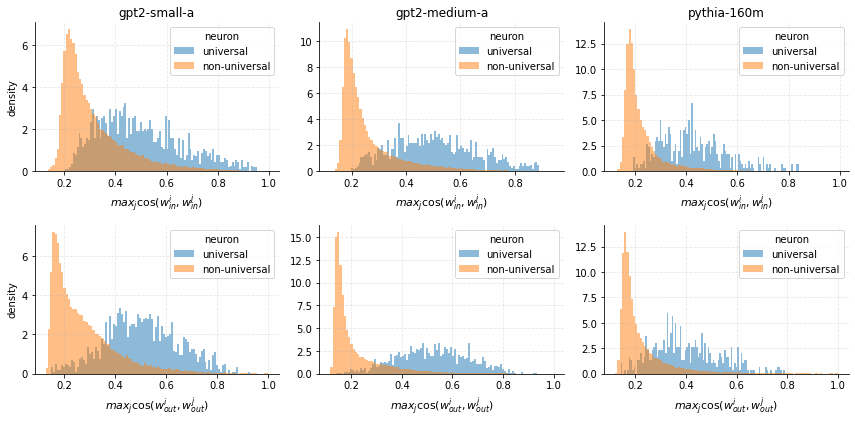

In [19]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for ix, model_name in enumerate(model_names):
    df = ndfs[model_name]
    sim_df = sim_dfs[model_name]
    is_universal = (df['excess_corr'] > 0.5).values
    max_out_sim = sim_df['max_out_sim'].values
    max_in_sim = sim_df['max_in_sim'].values

    ax = axs[0, ix]
    ax.hist(max_in_sim[is_universal], bins=100, alpha=0.5, label='universal', density=True);
    ax.hist(max_in_sim[~is_universal], bins=100, alpha=0.5, label='non-universal', density=True);

    ax.set_title(model_name.replace('stanford-', ''))
    ax.set_xlabel('$max_{j} \cos(w_{in}^i, w_{in}^j)$')
    if ix == 0:
        ax.set_ylabel('density')
    
    ax = axs[1, ix]
    ax.hist(max_out_sim[is_universal], bins=100, alpha=0.5, label='universal', density=True);
    ax.hist(max_out_sim[~is_universal], bins=100, alpha=0.5, label='non-universal', density=True);

    ax.set_xlabel('$max_{j} \cos(w_{out}^i, w_{out}^j)$')
    if ix == 0:
        ax.set_ylabel('density')

for ax in axs.flatten():
    ax.grid(alpha=0.3, linestyle='--')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # make xlabel font larger
    ax.xaxis.label.set_size(11)
    ax.legend(title='neuron')

plt.tight_layout()
    
plt.savefig('figures/max_weight_sim.png', dpi=100)

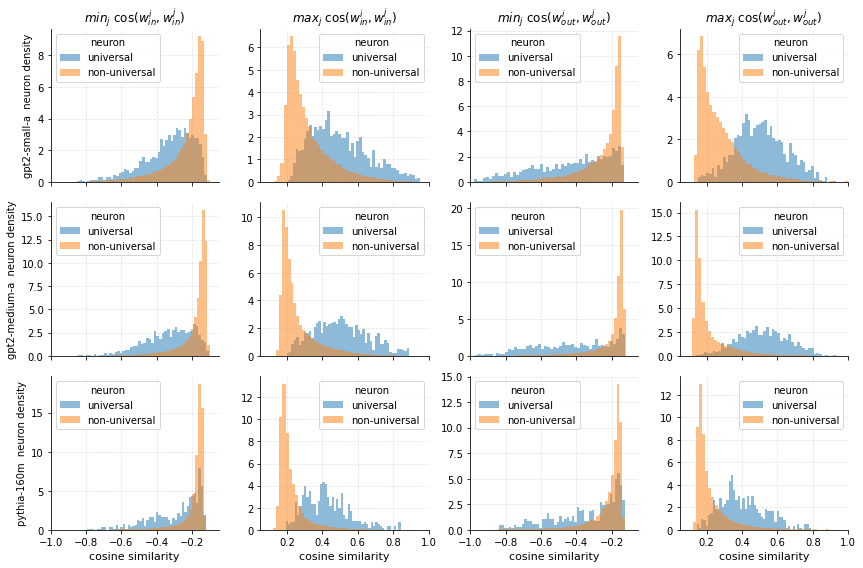

In [29]:
fig, axs = plt.subplots(3, 4, figsize=(12, 8))

titles = [
    '$min_{j} \ \cos(w_{in}^i, w_{in}^j)$', 
    '$max_{j} \ \cos(w_{in}^i, w_{in}^j)$', 
    '$min_{j} \ \cos(w_{out}^i, w_{out}^j)$', 
    '$max_{j} \ \cos(w_{out}^i, w_{out}^j)$'
]
for ix, model_name in enumerate(model_names):
    df = ndfs[model_name]
    sim_df = sim_dfs[model_name]
    is_universal = (df['excess_corr'] > 0.5).values
    max_out_sim = sim_df['max_out_sim'].values
    min_out_sim = sim_df['min_out_sim'].values
    max_in_sim = sim_df['max_in_sim'].values
    min_in_sim = sim_df['min_in_sim'].values

    data = [min_in_sim, max_in_sim, min_out_sim, max_out_sim]
    for jx, sim in enumerate(data):
        ax = axs[ix, jx]
        ax.hist(sim[is_universal], bins=50, alpha=0.5, label='universal', density=True);
        ax.hist(sim[~is_universal], bins=50, alpha=0.5, label='non-universal', density=True);

        if ix == 0:
            ax.set_title(titles[jx])

        if jx == 0:
            ax.set_ylabel(model_name.replace('stanford-', '') + '  neuron density')
        
        if jx % 2 == 0:
            ax.set_xlim(-1, -0.05)
        else:
            ax.set_xlim(0.05, 1)

        if ix == 2:
            ax.set_xlabel('cosine similarity')
        else:
            ax.set_xticklabels([])

for ax in axs.flatten():
    ax.grid(alpha=0.3, linestyle='--')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # make xlabel font larger
    ax.xaxis.label.set_size(11)
    ax.legend(title='neuron')

plt.tight_layout()
    
#plt.savefig('figures/max_weight_sim.png', dpi=100)

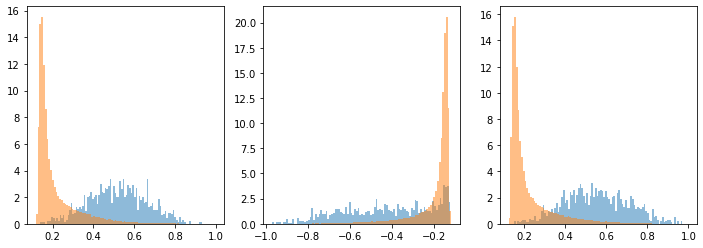

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
ax = axs[0]
ax.hist(max_out_sim[is_universal], bins=100, alpha=0.5, label='universal', density=True);
ax.hist(max_out_sim[~is_universal], bins=100, alpha=0.5, label='non-universal', density=True);

ax = axs[1]
ax.hist(min_out_sim[is_universal], bins=100, alpha=0.5, label='universal', density=True);
ax.hist(min_out_sim[~is_universal], bins=100, alpha=0.5, label='non-universal', density=True);

ax = axs[2]
ax.hist(max_abs_out_sim[is_universal], bins=100, alpha=0.5, label='universal', density=True);
ax.hist(max_abs_out_sim[~is_universal], bins=100, alpha=0.5, label='non-universal', density=True);

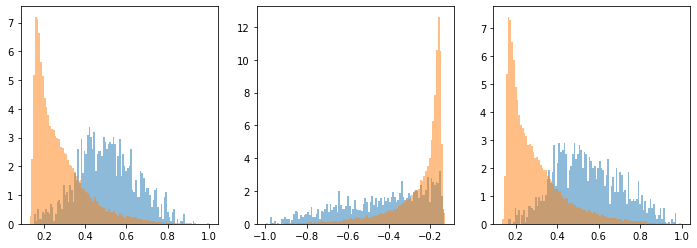

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
ax = axs[0]
ax.hist(max_out_sim[is_universal], bins=100, alpha=0.5, label='universal', density=True);
ax.hist(max_out_sim[~is_universal], bins=100, alpha=0.5, label='non-universal', density=True);

ax = axs[1]
ax.hist(min_out_sim[is_universal], bins=100, alpha=0.5, label='universal', density=True);
ax.hist(min_out_sim[~is_universal], bins=100, alpha=0.5, label='non-universal', density=True);

ax = axs[2]
ax.hist(max_abs_out_sim[is_universal], bins=100, alpha=0.5, label='universal', density=True);
ax.hist(max_abs_out_sim[~is_universal], bins=100, alpha=0.5, label='non-universal', density=True);

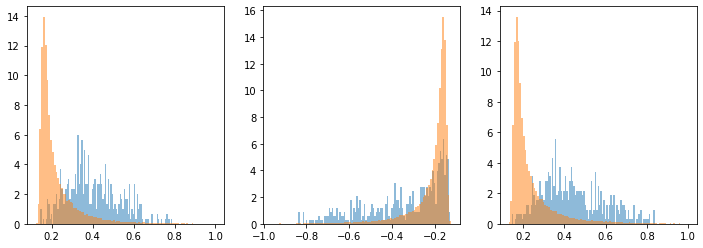

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
ax = axs[0]
ax.hist(max_out_sim[is_universal], bins=100, alpha=0.5, label='universal', density=True);
ax.hist(max_out_sim[~is_universal], bins=100, alpha=0.5, label='non-universal', density=True);

ax = axs[1]
ax.hist(min_out_sim[is_universal], bins=100, alpha=0.5, label='universal', density=True);
ax.hist(min_out_sim[~is_universal], bins=100, alpha=0.5, label='non-universal', density=True);

ax = axs[2]
ax.hist(max_abs_out_sim[is_universal], bins=100, alpha=0.5, label='universal', density=True);
ax.hist(max_abs_out_sim[~is_universal], bins=100, alpha=0.5, label='non-universal', density=True);

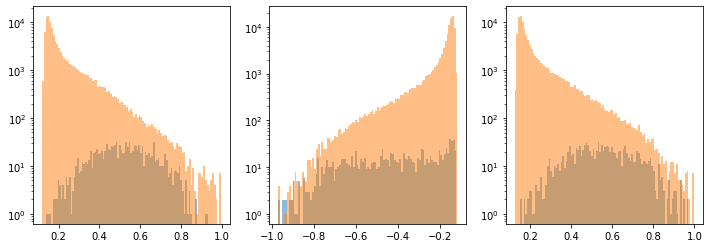

In [100]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
ax = axs[0]
ax.hist(max_out_sim[is_universal], bins=100, alpha=0.5, label='universal', log=True);
ax.hist(max_out_sim[~is_universal], bins=100, alpha=0.5, label='non-universal', log=True);

ax = axs[1]
ax.hist(min_out_sim[is_universal], bins=100, alpha=0.5, label='universal', log=True);
ax.hist(min_out_sim[~is_universal], bins=100, alpha=0.5, label='non-universal', log=True);

ax = axs[2]
ax.hist(max_abs_out_sim[is_universal], bins=100, alpha=0.5, label='universal', log=True);
ax.hist(max_abs_out_sim[~is_universal], bins=100, alpha=0.5, label='non-universal', log=True);

In [88]:
is_universal = (df['excess_corr'] > 0.5).values
min_in_sim = W_in_cos.min(axis=1)
max_in_sim = W_in_cos.max(axis=1)

In [92]:
max_abs_in_sim = np.abs(W_in_cos).max(axis=1)

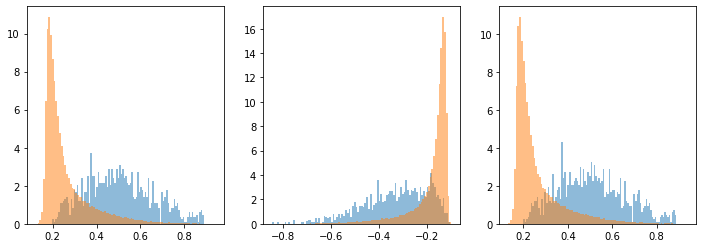

In [93]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
ax = axs[0]
ax.hist(max_in_sim[is_universal], bins=100, alpha=0.5, label='universal', density=True);
ax.hist(max_in_sim[~is_universal], bins=100, alpha=0.5, label='non-universal', density=True);

ax = axs[1]
ax.hist(min_in_sim[is_universal], bins=100, alpha=0.5, label='universal', density=True);
ax.hist(min_in_sim[~is_universal], bins=100, alpha=0.5, label='non-universal', density=True);

ax = axs[2]
ax.hist(max_abs_in_sim[is_universal], bins=100, alpha=0.5, label='universal', density=True);
ax.hist(max_abs_in_sim[~is_universal], bins=100, alpha=0.5, label='non-universal', density=True);

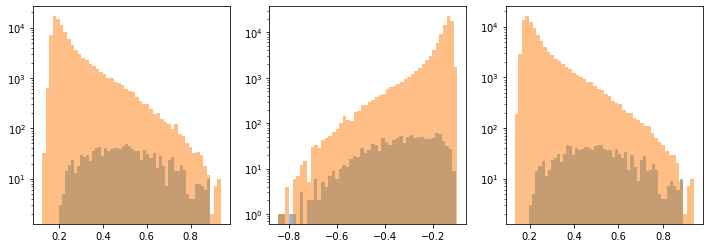

In [117]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
ax = axs[0]
ax.hist(max_in_sim[is_universal], bins=50, alpha=0.5, label='universal', log=True);
ax.hist(max_in_sim[~is_universal], bins=50, alpha=0.5, label='non-universal', log=True);

ax = axs[1]
ax.hist(min_in_sim[is_universal], bins=50, alpha=0.5, label='universal', log=True);
ax.hist(min_in_sim[~is_universal], bins=50, alpha=0.5, label='non-universal', log=True);

ax = axs[2]
ax.hist(max_abs_in_sim[is_universal], bins=50, alpha=0.5, label='universal', log=True);
ax.hist(max_abs_in_sim[~is_universal], bins=50, alpha=0.5, label='non-universal', log=True);



In [115]:
df['max_out_sim'] = max_out_sim
df['min_out_sim'] = min_out_sim
df['max_abs_out_sim'] = max_abs_out_sim
df['max_in_sim'] = max_in_sim
df['min_in_sim'] = min_in_sim
df['max_abs_in_sim'] = max_abs_in_sim

df['out_sim_range'] = df['max_out_sim'] - df['min_out_sim']
df['in_sim_range'] = df['max_in_sim'] - df['min_in_sim']

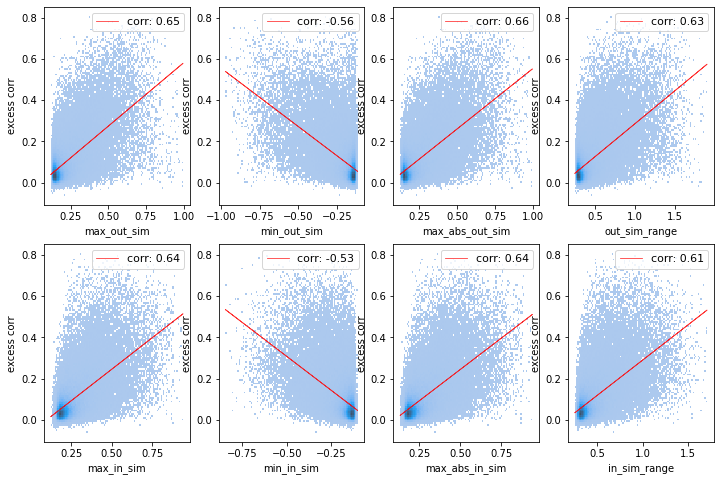

In [116]:
# histplot for max_out_sim, ..., max_abs_in_sim and excess_corr
fig, axes = plt.subplots(2, 4, figsize=(12, 8))

for i, col in enumerate(['max_out_sim', 'min_out_sim', 'max_abs_out_sim', 'out_sim_range', 'max_in_sim', 'min_in_sim', 'max_abs_in_sim', 'in_sim_range']):
    ax = axes[i//4, i%4]
    sns.histplot(df, x=col, y='excess_corr', ax=ax, bins=100)

    ax.set_xlabel(col)
    ax.set_ylabel('excess corr')

    # add best fit line
    x = df[col]
    y = np.nan_to_num(df['excess_corr'].values, 0)
    corr = np.corrcoef(x, y)[0, 1]
    m, b = np.polyfit(x, y, 1)

    ax.plot(x, m*x + b, color='red', lw=0.8,alpha=0.8, label=f'corr: {corr:.2f}')
    ax.legend(loc='upper right', fontsize=11)




In [110]:
y.isna().sum()

5

In [125]:
df.query('excess_corr > 0.5 and layer == 6').sort_values('excess_corr').head(20)

,layer,neuron,max_corr,mean_corr,min_corr,max_baseline,min_baseline,mean_baseline,w_in_norm,input_bias,w_out_norm,in_out_sim,l2_penalty,mean,var,skew,kurt,vocab_mean,vocab_var,vocab_skew,vocab_kurt,sparsity,excess_corr,max_out_sim,min_out_sim,max_abs_out_sim,max_in_sim,min_in_sim,max_abs_in_sim,out_sim_range,in_sim_range
28259,6,3683,0.6590,0.623000,0.5620,0.1294,0.11700,0.122690,0.585729,-0.552785,0.457815,-0.009771,0.552672,-1.796318,0.481278,1.088827,4.732180,-0.000007,0.001096,0.099062,3.046747,0.027681,0.500310,0.519425,-0.504881,0.519425,0.605227,-0.504993,0.605227,1.024306,1.110219
25848,6,1272,0.9130,0.877150,0.8200,0.3901,0.36130,0.375100,0.221972,-0.111762,0.355446,-0.069808,0.175613,-0.658459,0.144743,0.995087,4.333968,0.000444,0.001054,-0.199370,4.556984,0.086424,0.502050,0.668808,-0.460128,0.668808,0.666429,-0.332413,0.666429,1.128936,0.998842
27505,6,2929,0.7725,0.675300,0.5550,0.1758,0.16910,0.173075,0.762987,-0.763899,0.637708,0.383261,0.988820,-2.268741,0.630497,-0.276874,6.336721,0.000185,0.000859,0.022763,3.074475,0.005664,0.502225,0.411077,-0.296065,0.411077,0.451366,-0.313333,0.451366,0.707143,0.764699
27601,6,3025,0.6885,0.662975,0.6064,0.1638,0.14640,0.154575,0.678527,-0.663986,0.468354,0.356515,0.679754,-1.705467,0.492300,0.778297,5.595536,-0.000261,0.001323,0.653645,4.561545,0.020862,0.508400,0.378459,-0.241937,0.378459,0.262051,-0.170097,0.262051,0.620396,0.432148
26351,6,1775,0.6960,0.655075,0.6113,0.1587,0.13980,0.146075,0.653877,-0.704905,0.498840,0.316980,0.676397,-2.009996,0.686999,0.604752,4.039545,0.000182,0.000970,-0.009800,3.024268,0.022094,0.509000,0.413179,-0.354416,0.413179,0.524481,-0.237380,0.524481,0.767596,0.761862
25897,6,1321,0.7560,0.622850,0.5410,0.1304,0.10284,0.113785,0.359044,-0.338836,0.418537,-0.730399,0.304085,-1.205396,0.806504,-0.228657,2.231287,0.000287,0.000815,-0.001874,3.388429,0.114167,0.509065,0.604917,-0.526732,0.604917,0.750620,-0.528763,0.750620,1.131648,1.279383
27817,6,3241,0.7295,0.704375,0.6460,0.2023,0.18700,0.194850,0.262855,-0.036310,0.418343,-0.638550,0.244104,-0.196241,0.235598,-0.573318,3.520431,-0.000388,0.000887,0.019478,2.979676,0.455456,0.509525,0.778277,-0.656593,0.778277,0.549025,-0.361882,0.549025,1.434870,0.910907
25774,6,1198,0.7280,0.689850,0.6514,0.1852,0.17260,0.179200,0.732495,-0.800962,0.643111,0.278325,0.950140,-2.104853,0.527236,0.218254,3.971720,0.000147,0.000951,0.070388,3.060482,0.005553,0.510650,0.560086,-0.205542,0.560086,0.458431,-0.131142,0.458431,0.765628,0.589573
27633,6,3057,0.7153,0.625575,0.5894,0.1064,0.09240,0.097827,0.707833,-0.688960,0.416680,0.337434,0.674650,-2.303575,0.479996,1.101442,6.939048,0.000469,0.001023,0.055529,2.991323,0.009208,0.527748,0.608445,-0.538691,0.608445,0.546418,-0.355329,0.546418,1.147137,0.901747
26815,6,2239,0.7017,0.650325,0.6040,0.1190,0.11237,0.115812,0.588094,-0.712848,0.578852,-0.360805,0.680924,-2.181580,0.409277,1.341762,6.185687,0.001159,0.001902,-0.301791,2.861478,0.013632,0.534513,0.605882,-0.611693,0.611693,0.749566,-0.421614,0.749566,1.217574,1.171180


In [132]:
W_U = model.W_U.T.cpu().numpy()

In [135]:
W_U.shape

(50257, 1024)

In [41]:
# cos sim between W_U and x
x = np.random.randn(W_U.shape[1])

x_norm = x / np.linalg.norm(x)
W_U_norm = W_U #/ np.linalg.norm(W_U, axis=1)[:, None]

cos_sim = W_U_norm @ x_norm

NameError: name 'W_U' is not defined

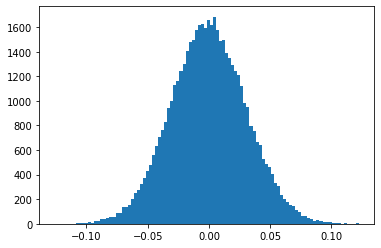

In [ ]:
plt.hist(cos_sim, bins=100);

In [ ]:
# kurtosis of cos_sim
from scipy.stats import kurtosis

kurtosis(cos_sim) + 3

3.039439475378782